# GenVeg Main Script
## Test dune vegetation implementation
GenVeg is a generalized vegetation growth model that simulates growth due to
photosynthesis as well as processes that control vegetation distribution such
as mortality, senescence, dispersal, and colonization. The model utilizes a 
mixture of existing and new Landlab components to setup the model, simulates
relevant vegetation community dynamics with the local environment, and analyzes
results of the simulation. 

## Main model control set up
### Import components

In [1]:
import numpy as np, pandas as pd
import os, tempfile
from pathlib import Path
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection, LineCollection
from landlab import RasterModelGrid, imshow_grid, load_params
from landlab.data_record import DataRecord
from landlab.components.genveg import VegParams, GenVeg
from landlab.io.netcdf import write_netcdf, read_netcdf
from scipy.io import netcdf_file
from noaa_coops import Station

### Define time controls

This sets up a one-year run with a daily timestep.

In [2]:
sim_start_date = np.datetime64('2010-01-01')
sim_end_date = np.datetime64('2015-08-10')
veg_time_step_d = 1
env_time_step_d = 1
dt=np.timedelta64(min([veg_time_step_d,env_time_step_d]),'D')
run_length_d=(sim_end_date-sim_start_date).astype(int)

### Define filenames for input files
##### *Note should be located in same folder as this .ipynb

In [3]:
working_dir_path=Path.cwd()
veg_input_file = 'GenVeg_Dune_Simulation.xlsx'

### Read in parameter and data input files
Identify model processes to be included so all required parameters are defined and calculated

In [4]:
inp_file_path=working_dir_path.joinpath(veg_input_file)
VegParams(fpath=inp_file_path,processes=['plantsize','dispersal','mortality'])
vegparams=load_params('veg_params.yml')


D:\Python\landlab\landlab\components\genveg\load_veg_params.py:438: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + a * np.exp(-b * x))


In [5]:
print(vegparams)

{'BTS': {'col_params': {'prob_colonization': 0.01, 'time_to_colonization': 365}, 'dispersal_params': {'max_dist_dispersal': 0.4, 'min_size_dispersal': 0.5, 'unit_cost_dispersal': 1.2}, 'duration_params': {'growing_season_end': 305, 'growing_season_start': 144, 'reproduction_end': 250, 'reproduction_start': 180, 'senescence_start': 273}, 'grow_params': {'glucose_requirement': {'leaf': 1.463, 'reproductive': 1.414, 'root': 1.444, 'stem': 1.513}, 'growth_max_biomass': 13.899999999999999, 'growth_min_biomass': 0.06222222222222222, 'incremental_nsc': {'leaf': [1.25, 0, -1, 0.5], 'reproductive': [1.5625, -1.875, 0.0625, 2.5], 'root': [1.25, -2.5, 0, 2], 'stem': [0, -0.5, 0, 0.5]}, 'k_light_extinct': 0.48, 'light_half_sat': 100, 'max_nsc_content': {'leaf': 0.36629, 'reproductive': 0.36643, 'root': 0.36643, 'stem': 0.30964}, 'min_nsc_content': {'leaf': 0.01548, 'reproductive': 0.01071, 'root': 0.01071, 'stem': 0.0075}, 'nsc_content': {'leaf': 0.17396, 'reproductive': 0.21429, 'root': 0.21429, 

In [6]:
env_fname='data\POWER_Point_Daily_20091231_20151230_039d81N_074d09W_LST.csv'
env_data_file_path = working_dir_path.joinpath(env_fname)
env_data=np.genfromtxt(env_data_file_path, dtype={'names': ('year','doy','par_Wm^-2','temp_C','precip_mm','root_sm','wind_sp','wid_dir'),'formats': ('int', 'int', 'f8', 'f8','f8', 'f8', 'f8', 'f8', 'f8')}, delimiter=',', skip_header=16) 

This code block reads in 6-minute water level data from NOAA CO-OPs and calculates a daily mean. Only run once to save the daily csv.

In [7]:
#AC=Station(id=8534720)
#df_water_levels = AC.get_data(
#    begin_date="20100101",
#    end_date="20151231",
#    product="water_level",
#    datum="MSL",
#    units="metric",
#    time_zone="lst")

#df_water_levels.head()
#df_water_levels=pd.read_csv(water_levelfilename)
#daily_wl=df_water_levels.resample('D').mean()
#daily_wl.to_csv('D:\\Python\\landlab\\notebooks\\GenVeg\\data\\water_level.csv', index=False)

Read in the daily water level csv and construct a 7-day rolling average of water levels as a Numpy data array.

In [8]:
water_level_filename='data\water_level.csv'
water_level_file_path=working_dir_path.joinpath(water_level_filename)
df_water_levels=pd.read_csv(water_level_file_path)
df_water_levels.interpolate(method='linear', inplace=True)
df_WL_MA=df_water_levels.rolling(7)
water_level=df_water_levels['v'].to_numpy()

For this implementation, we are taking a snippet of the existing DOONIES Island Beach State Park initial domain. Ideally, you would read in a raster topobathy file. This file must be rotated so the ocean is to left and the shoreline is parallel to the y-axis. This is the convention of many cross-shore morphology models but in the future the distance to shore function defined in this notebook can be expanded to rotate the file to the correct orientation.

In [9]:
grid_elev=np.array([
0.628200908436216, 0.679888087290815, 0.722742172094999, 0.755851097267735, 0.779368661035206, 0.794378719218604,
0.622171003154823, 0.676451944089383, 0.722148619144433, 0.757930660758653, 0.783614747564674, 0.800081633200742,
0.609596301596975, 0.668136863036746, 0.718783543700898, 0.759505640937312, 0.789491256227331, 0.809169986950099,
0.588280110259446, 0.651780322420748, 0.708848777200529, 0.756618493511150, 0.793383400939227, 0.818779031470970,
0.557294741401334, 0.624849672801927, 0.688405652226345, 0.744392337159210, 0.790095204553699, 0.824012601441663,
])
grid_elev.size

30

### Set up model grid using landlab RasterModelGrid functions

- Create the model grid
- Initialize the air temperature driver across the grid
- Initialize the photosynthetically active radiation across the grid
- Initialize the elevation relative to sea level
- Initialize mortality variables: elevation above water level and distance to shore
- Initialize vegetation percent cover and randomly assign vegetation species in each grid cell

##### **Note variable names should be consistent with landlab standards

In [10]:
#Create grid 22x32 node grid with 2 m node spacing and xy of origin in lat long roughly corresponding to Island Beach State Park
pg = RasterModelGrid((7, 8), 2, xy_of_reference=(-74.08,39.79))
pg.axis_units = ('m', 'm')

#Create dummy datasets of mean monthly temperature, PAR, distance to the shore, and elevation relative to sea level
meantemp=env_data['temp_C']
NJ_avg_par=env_data['par_Wm2']                

#Initialize with a dummy data sets 
_ = pg.add_field('air__temperature_C', meantemp[0]*np.ones(pg.number_of_cells), at='cell', units='C' )
_ = pg.add_field('radiation__par_tot', NJ_avg_par[0]*np.ones(pg.number_of_cells), at='cell', units='W/m^2')
_ = pg.add_field('elevation__MSL_m', grid_elev, at='cell', units='m_MSL')
_ = pg.add_field('elevation__above_WL', grid_elev-water_level[0], at='cell', units='m')

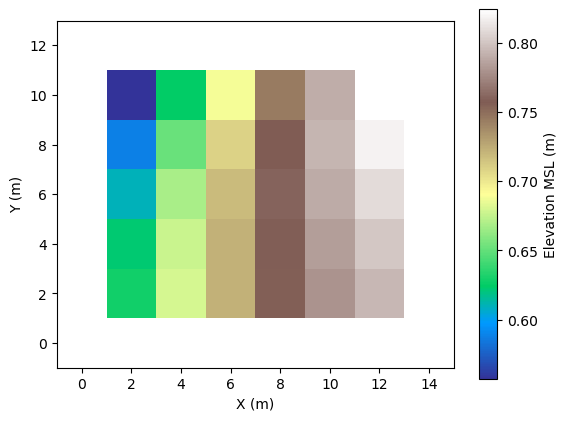

In [11]:
imshow_grid(pg, 'elevation__MSL_m', at='cell',colorbar_label='Elevation MSL (m)', cmap='terrain')

These next cells calculate the distance to shore. First we define the function and then apply it. Note the function assumes the elevation grid is in the correct orientation.

This function calculates the distance to shore from a grid input.

In [12]:
def calc_dist2shore(rmg):
    core_nodes=rmg.core_nodes
    x=rmg.node_axis_coordinates(0)
    x=x[core_nodes]
    y=rmg.node_axis_coordinates(1)
    y=y[core_nodes]
    z=rmg['cell']['elevation__above_WL']
    num_rows=np.unique(x)
    dist2shore=np.zeros_like(grid_elev)
    for row in num_rows:
        row_loc=np.nonzero(x==row)
        row_x=x[row_loc]
        row_y=y[row_loc]
        row_z=z[row_loc]
        inundated=np.nonzero(row_z<0)
        shore_cell_idx=inundated[-1]
        if shore_cell_idx.size <=0:
            m=(row_z[1]-row_z[0])/(row_y[1]-row_y[0])
            b=row_z[0]-m*row_y[0]
            shore_y=(0-b)/m

        else:
            wet_cell=shore_cell_idx[-1]
            dry_cell=wet_cell+1
            shore_z_wet=row_z[wet_cell]
            shore_y_wet=row_y[wet_cell]
            shore_z_dry=row_z[dry_cell]
            shore_y_dry=row_y[dry_cell]
            m=(shore_z_wet-shore_z_dry)/(shore_y_wet-shore_y_dry)
            b=shore_z_wet-m*shore_y_wet
            shore_y=(0-b)/m

        shore_dist=row_y-shore_y
        dist2shore[row_loc]=shore_dist
    return dist2shore

Calculate distance to shore and save as Distance to shore variable in raster model grid object.

In [13]:
dist2shore=calc_dist2shore(pg)
_ = pg.add_field('Distance to shore', dist2shore, at='cell', units='m', clobber=True)


Now we visualize the grid initial conditions and save some of the plots for later use. 

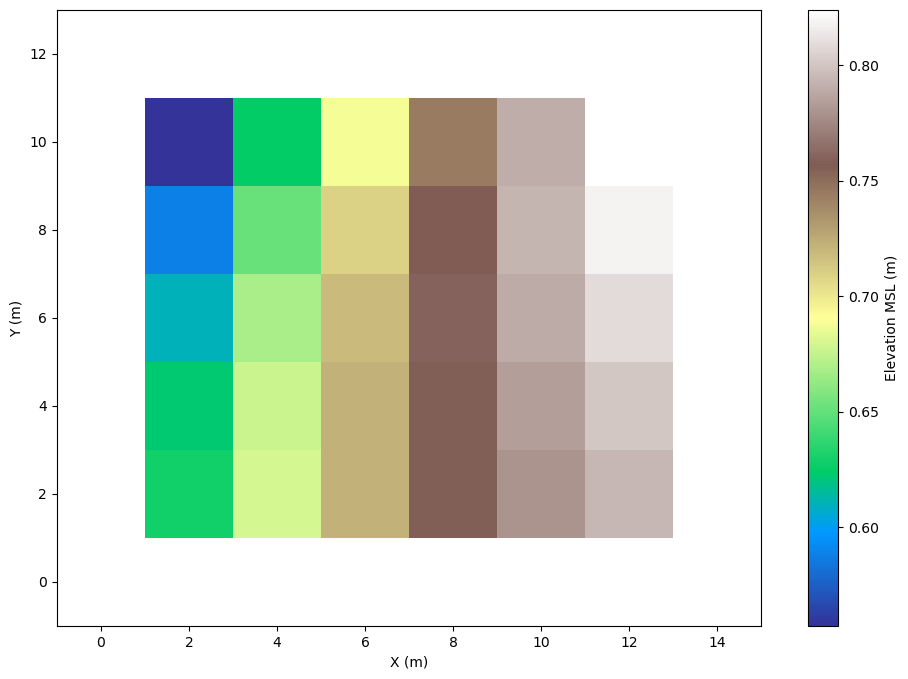

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'elevation__MSL_m', at='cell',colorbar_label='Elevation MSL (m)', cmap='terrain')
fig.savefig("D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init_elevation.png", dpi=300, bbox_inches="tight")

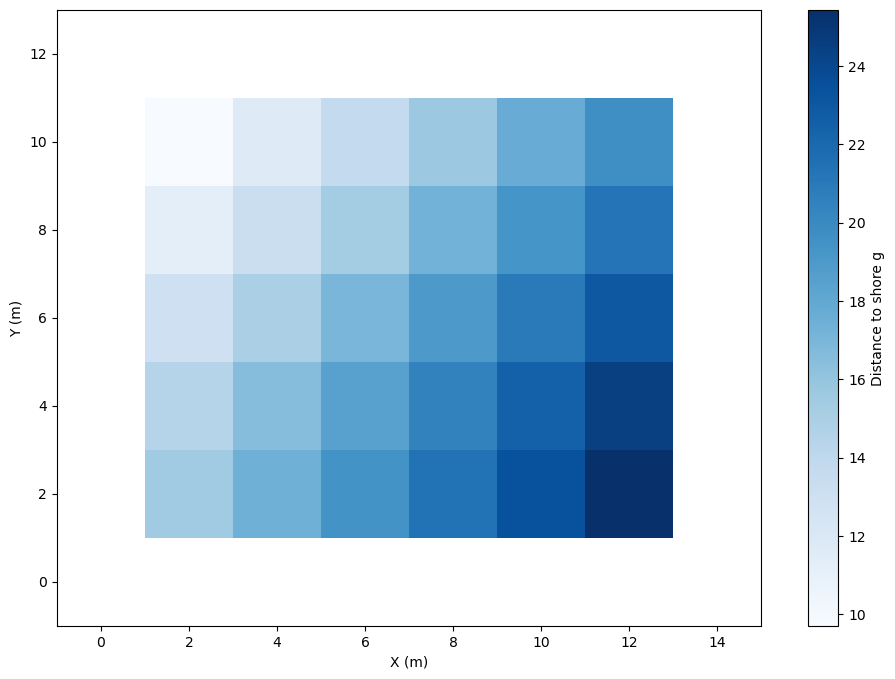

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'Distance to shore', at='cell', colorbar_label='Distance to shore g', cmap='Blues')
fig.savefig("D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init_dist2shore.png", dpi=300, bbox_inches="tight")


Here we initialize a cell percent cover across the entire grid. This means plants will be placed in locations we know they will not survive. Initial percent cover is randomly assigned between 0 and 20% and cells are randomly assigned to be populated by just dune builders, just burial tolerant stabilizers, or a mix of the two.

In [16]:
#Initialize plant functional type as burial tolerant stabilizer or dune builder and randomly place on grid
_ = pg.add_field('vegetation__percent_cover', np.random.default_rng().uniform(low=0.0, high=0.2, size=pg.number_of_cells), at='cell', clobber=True)
plant_list=[['DB','null'],['DB','BTS'],['null','BTS']]
_ = pg.add_field('vegetation__plant_species',np.random.default_rng().choice(plant_list,pg.number_of_cells), at='cell', clobber=True)


### Initialize the GenVeg component and visualize initial plant metrics.

Initialize dune GenVeg class with veg_params from Excel file

In [17]:
foredune=GenVeg(pg,dt,sim_start_date,vegparams)

Now we visualize some of the vegetation metrics on the grid and save some of the plots.

In [18]:
first_species=foredune.plant_species[0]
print(first_species.species_duration_params)

{'growing_season_end': 305, 'growing_season_start': 144, 'reproduction_end': 250, 'reproduction_start': 180, 'senescence_start': 273, 'senesce_rate': 0.028125, 'nsc_rate_change': {'dormant_nsc_rate': {'leaf': 0.003676470588235294, 'reproductive': -0.004595588235294118, 'root': -0.003676470588235294, 'stem': -0.0024509803921568627}, 'growth_nsc_rate': {'leaf': -0.034722222222222224, 'reproductive': -0.0954861111111111, 'root': -0.10416666666666667, 'stem': -0.013888888888888888}, 'repro_nsc_rate': {'leaf': -0.010752688172043012, 'reproductive': 0.020833333333333332, 'root': 0.026881720430107527, 'stem': 0.005376344086021506}, 'senesce_nsc_rate': {'leaf': 0.046875, 'reproductive': 0.076171875, 'root': 0.0625, 'stem': 0.015625}}}


In [19]:
second_species=foredune.plant_species[1]
print(second_species.species_duration_params)

{'growing_season_end': 243, 'growing_season_start': 121, 'max_age': 1000, 'reproduction_end': 226, 'reproduction_start': 140, 'senescence_start': 228, 'senesce_rate': 0.060000000000000005, 'nsc_rate_change': {'dormant_nsc_rate': {'leaf': 0.0030864197530864196, 'reproductive': -0.0038580246913580245, 'root': -0.0030864197530864196, 'stem': -0.00205761316872428}, 'growth_nsc_rate': {'leaf': -0.06578947368421052, 'reproductive': -0.18092105263157895, 'root': -0.19736842105263158, 'stem': -0.02631578947368421}, 'repro_nsc_rate': {'leaf': -0.011363636363636364, 'reproductive': 0.022017045454545456, 'root': 0.028409090909090908, 'stem': 0.005681818181818182}, 'senesce_nsc_rate': {'leaf': 0.1, 'reproductive': 0.1625, 'root': 0.13333333333333333, 'stem': 0.03333333333333333}}}


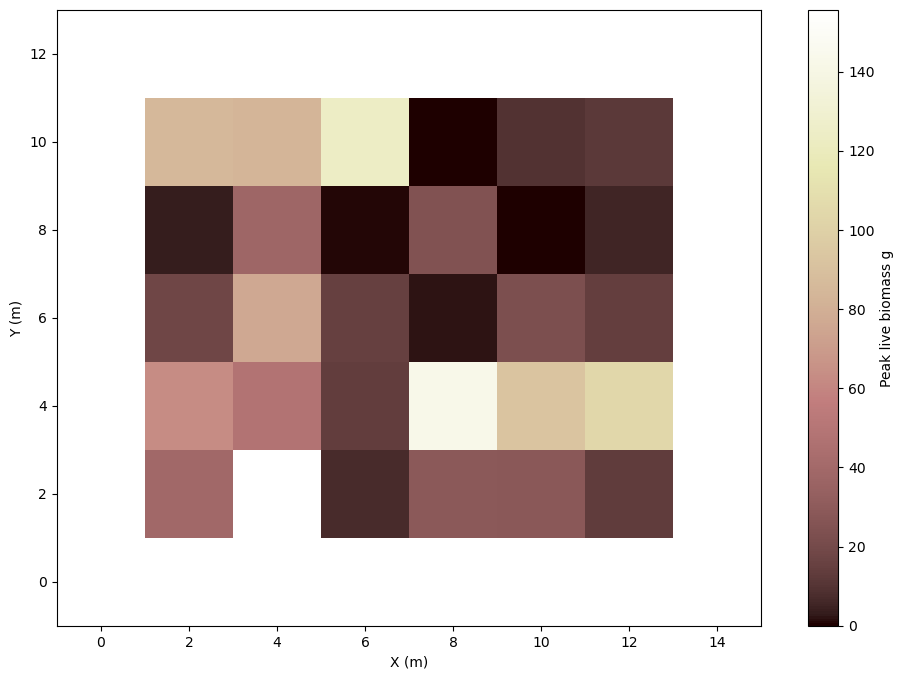

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Peak live biomass g')
fig.savefig("D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init_peak_biomass.png", dpi=300, bbox_inches="tight")

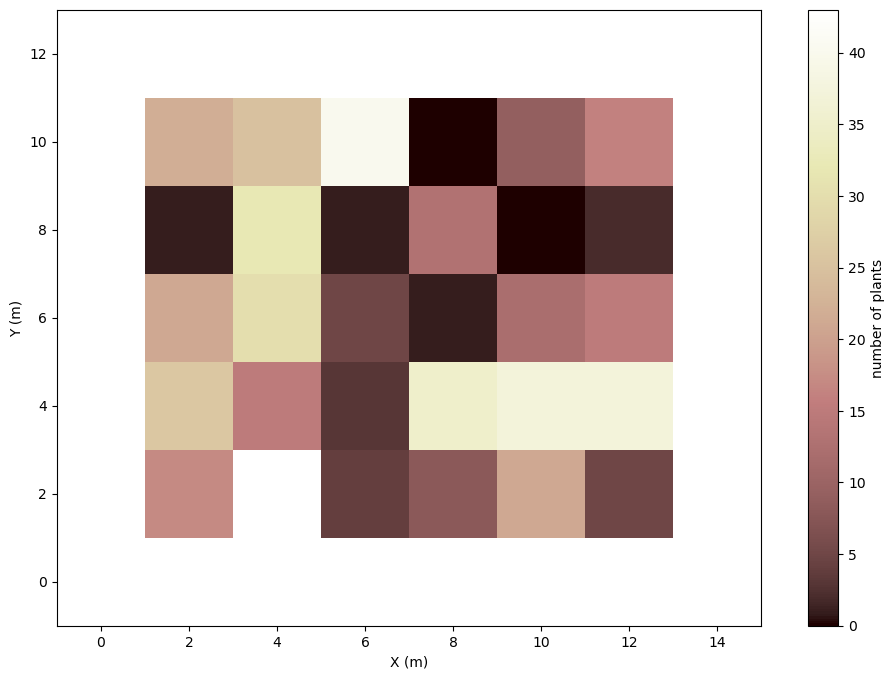

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants')
fig.savefig("D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init_n_plants.png", dpi=300, bbox_inches="tight")


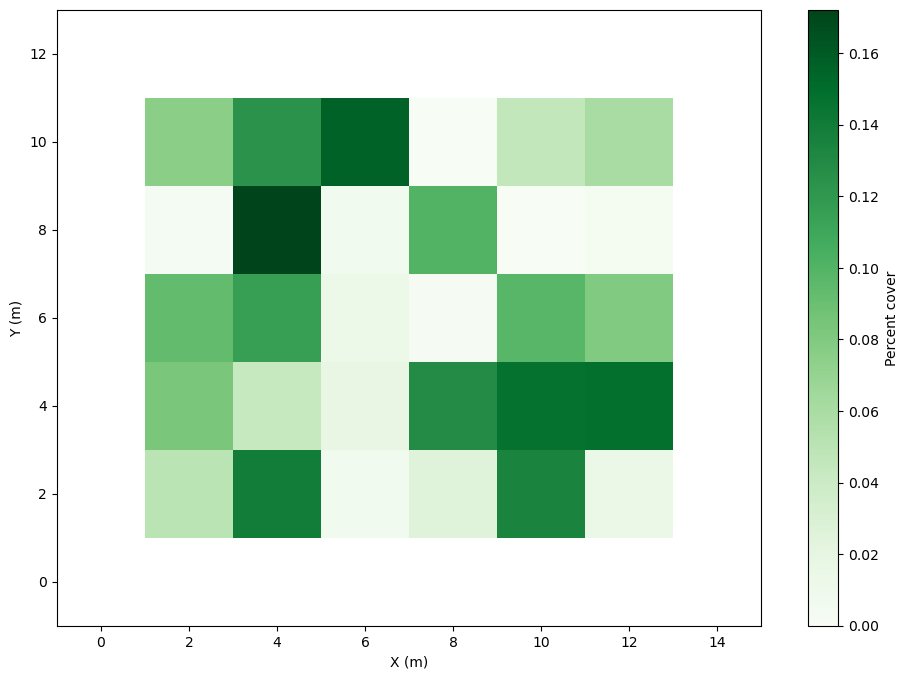

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'vegetation__percent_cover', at='cell', colorbar_label='Percent cover', cmap='Greens')
fig.savefig("D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init_pcover.png", dpi=300, bbox_inches="tight")

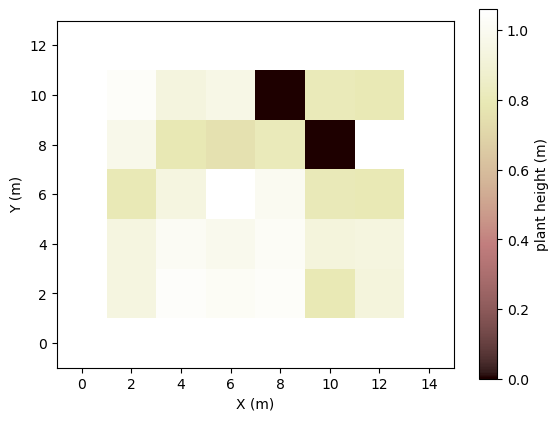

In [23]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)')

We save each species plant array separately so we can plot them individually.

In [24]:
DB=pd.DataFrame(foredune.plant_species[1].species_plants())
BTS=pd.DataFrame(foredune.plant_species[0].species_plants())

In [25]:
def print_plant_locs(filepathname, plant_locs_df_names, width_var):
    fig, ax = plt.subplots(figsize=(12,8)) #figsize in inches
    imshow_grid(pg, 'elevation__MSL_m', at='cell', colorbar_label='Elevation relative to MSL (m)', cmap='terrain')
    ax=plt.gca()
            
    plant_locs_db=plant_locs_df_names[0][['x_loc','y_loc']].to_numpy()
    sizes_db=DB[width_var].values
    blue_patches=[]
    for idx,center in enumerate(plant_locs_db):
        circle = plt.Circle(center, sizes_db[idx], alpha=0.5, color='blue')
        blue_patches.append(circle)
        #ax.add_patch(circle)
    blue_coll=PatchCollection(blue_patches, alpha=0.7)
    blue_coll.set_color('blue')
    ax.add_collection(blue_coll)

    plant_locs_bts=plant_locs_df_names[1][['x_loc','y_loc']].to_numpy()
    sizes_bts=BTS[width_var].values
    orange_patches=[]
    for idx,center in enumerate(plant_locs_bts):
        circle = plt.Circle(center, sizes_bts[idx], alpha=0.5, color='orange')
        orange_patches.append(circle)
        #ax.add_patch(circle)

    orange_coll=PatchCollection(orange_patches, alpha=0.7)
    orange_coll.set_color('orange')
    ax.add_collection(orange_coll)
    fig.savefig(filepathname, dpi=300, bbox_inches="tight") # the bbox_inches removes whitespace around the plot

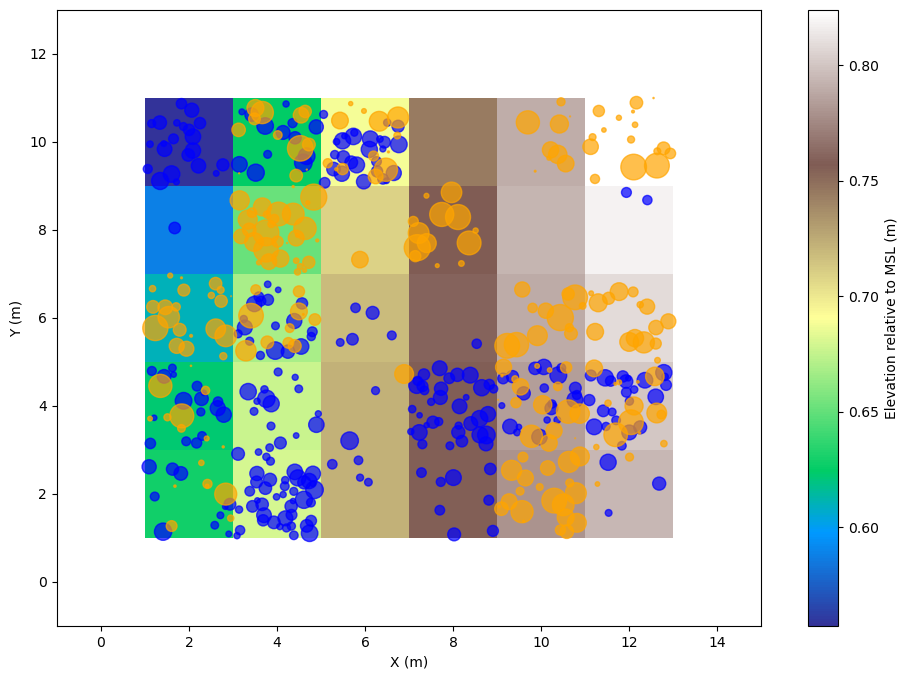

In [26]:
initial_plant_locs_fpath="D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init_elevation.png"
print_plant_locs(initial_plant_locs_fpath, [DB,BTS], "root_sys_width")

## Main model loop script
This is the main model loop that controls the simulation that
- Advances model time 
- Updates environmental variables
- Simulates changes to vegetation communities
- Stores outputs
    - Individual plants characteristics as DataRecords
    - Grid outputs to a NetCDF format

0
BTS
62 were too small to survive
0
DB
12 were too small to survive
1
BTS
1
DB
2
BTS
2
DB
1 were too small to survive
3
BTS
3
DB
1 were too small to survive
4
BTS
4
DB
5
BTS
5
DB
6
BTS
6
DB
7
BTS
7
DB
8
BTS
8
DB
9
BTS
9
DB
10
BTS
10
DB
1 were too small to survive
11
BTS
11
DB
12
BTS
12
DB
13
BTS
13
DB
14
BTS
14
DB
15
BTS
15
DB
2 were too small to survive
16
BTS
16
DB
17
BTS
17
DB
18
BTS
18
DB
19
BTS
19
DB
20
BTS
20
DB
21
BTS
21
DB
22
BTS
22
DB
23
BTS
23
DB
24
BTS
24
DB
25
BTS
25
DB
26
BTS
26
DB
27
BTS
27
DB
28
BTS
28
DB
1 were too small to survive
29
BTS
29
DB
30
BTS
30
DB
31
BTS
31
DB
32
BTS
32
DB
33
BTS
1 were too small to survive
33
DB
34
BTS
34
DB
35
BTS
35
DB
36
BTS
36
DB
37
BTS
37
DB
38
BTS
38
DB
39
BTS
39
DB
40
BTS
40
DB
41
BTS
41
DB
42
BTS
42
DB
1 were too small to survive
43
BTS
43
DB
44
BTS
44
DB
45
BTS
45
DB
46
BTS
46
DB
47
BTS
47
DB
1 were too small to survive
48
BTS
48
DB
49
BTS
49
DB
50
BTS
50
DB
1 were too small to survive
51
BTS
51
DB
52
BTS
52
DB
53
BTS
53
DB
54
BTS
5

D:\Python\landlab\landlab\components\genveg\species.py:471: RuntimeWarning: overflow encountered in divide
  cohort_init_mass = sum_dead_mass / np.exp(
D:\Python\landlab\landlab\components\genveg\species.py:478: RuntimeWarning: invalid value encountered in multiply
  cohort_init_mass[filter]


245
BTS
I am photosynthesizing during the growing season
245
DB
I create new plants
Successful dispersal occurred
246
BTS
I am photosynthesizing during the growing season
246
DB
I create new plants
Successful dispersal occurred
247
BTS
I am photosynthesizing during the growing season
247
DB
I create new plants
Successful dispersal occurred
248
BTS
I am photosynthesizing during the growing season
248
DB
I create new plants
Successful dispersal occurred
249
BTS
I am photosynthesizing during the growing season
249
DB
I create new plants
Successful dispersal occurred
250
BTS
I am photosynthesizing during the growing season
250
DB
251
BTS
I am photosynthesizing during the growing season
251
DB
252
BTS
I am photosynthesizing during the growing season
252
DB
253
BTS
I am photosynthesizing during the growing season
253
DB
254
BTS
I am photosynthesizing during the growing season
254
DB
255
BTS
I am photosynthesizing during the growing season
255
DB
256
BTS
I am photosynthesizing during the grow

IndexError: index 6 is out of bounds for axis 0 with size 6

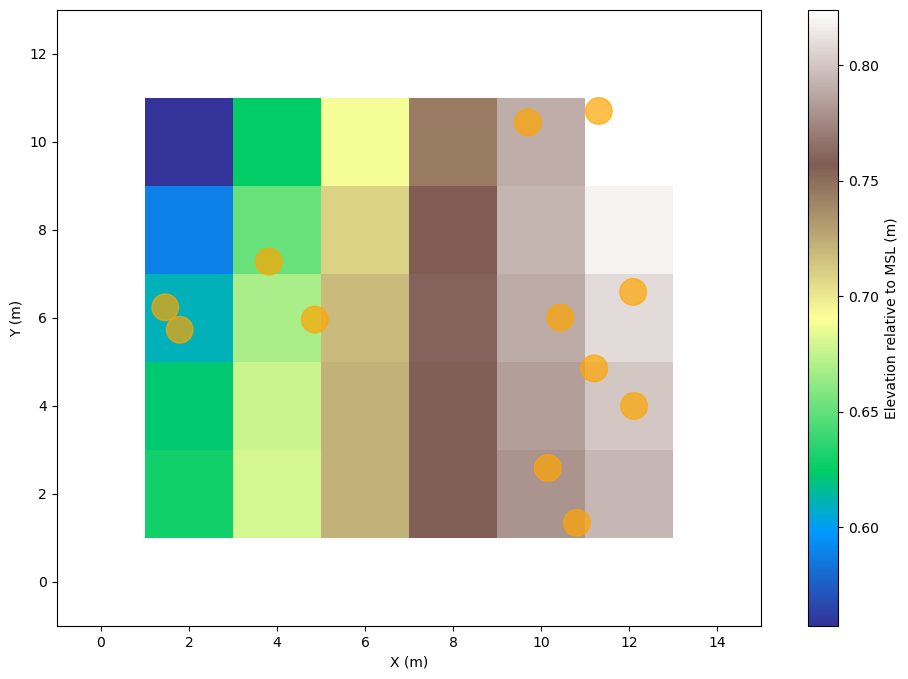

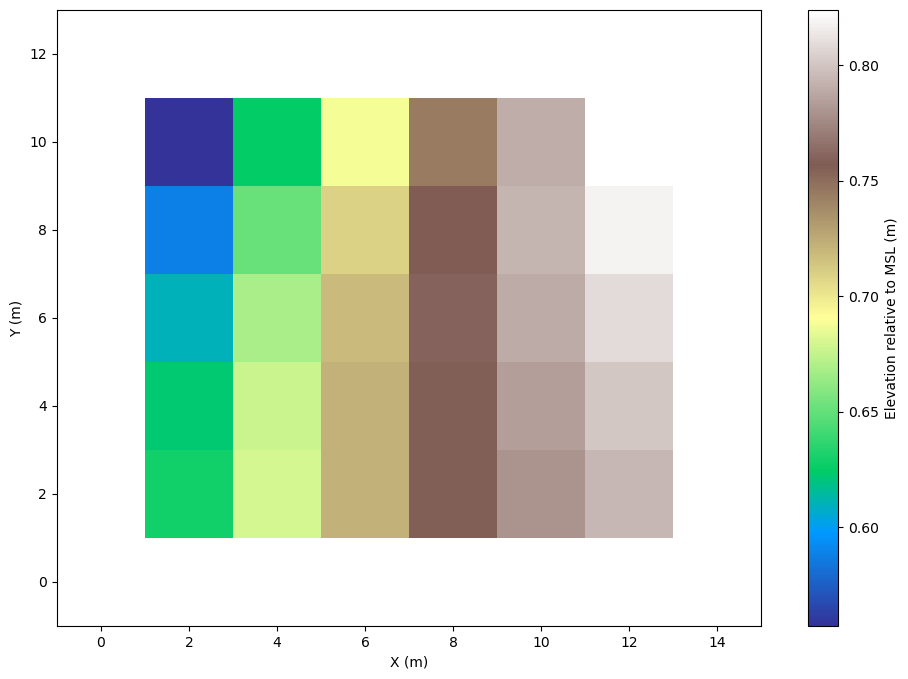

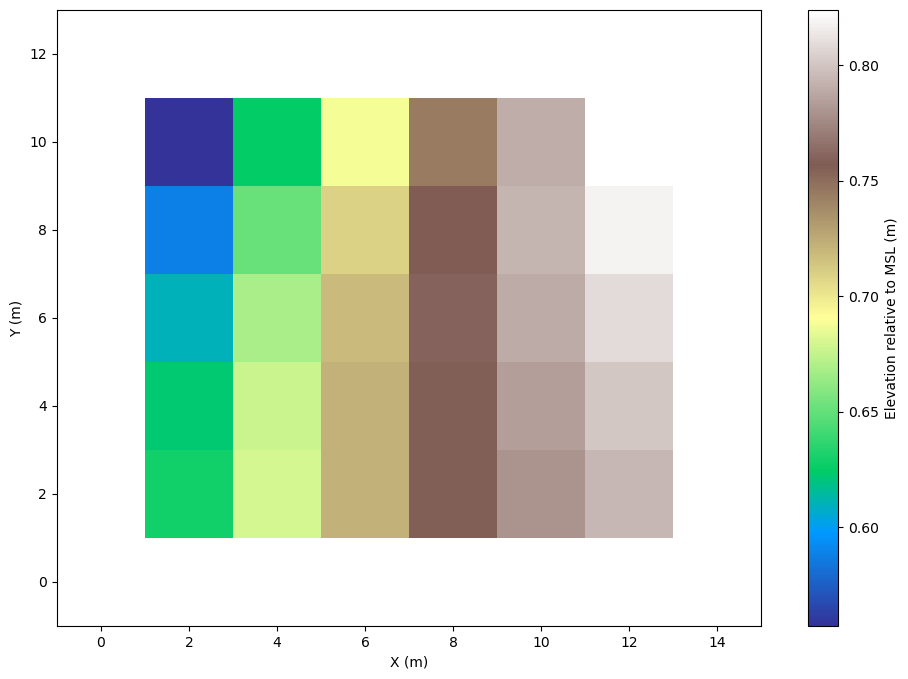

In [27]:
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)
save_points=[220, 220+365, 220+365+366, 220+365+366+365, 220+365+366+365+365]
for i in range(run_length_d):
    #update temp attribute on grid
    pg.at_cell['air__temperature_C']= meantemp[i]*np.ones(pg.number_of_cells)
    pg.at_cell['radiation__par_tot']= NJ_avg_par[i]*np.ones(pg.number_of_cells)
    pg.at_cell['elevation__above_WL']=pg.at_cell['elevation__MSL_m']-water_level[i]
    dist2shore=calc_dist2shore(pg)
    foredune.run_one_step()
    
    if (i in save_points):
        DB=pd.DataFrame(foredune.plant_species[1].species_plants())
        BTS=pd.DataFrame(foredune.plant_species[0].species_plants())
        initial_plant_locs_fpath="D:\\Python\\landlab\\notebooks\\GenVeg\\figure_"+str(i)+".png"
        print_plant_locs(initial_plant_locs_fpath, [DB,BTS], "shoot_sys_width")

    if (i/4).is_integer():
        foredune.save_output()
        write_netcdf("dune.nc",pg, format="NETCDF3_64BIT",append=True, time=(foredune.current_day-foredune.start_date).astype(float)-1, names=['vegetation__total_biomass', 'vegetation__n_plants', 'vegetation__percent_cover'])
        #imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Total Biomass (g)')


Now we look at some of the outputs. The get_plant_output method returns a Pandas Dataframe of the plant DataRecords. By default, all species are included but individual species can be specified as well.

In [28]:
output=foredune.get_plant_output()

To explore the output, the key order is [timestep, species, item_id]
The following shows all dune builders at timestep 0.

In [29]:
output.loc[:, 'BTS',16]

,grid_element,element_id,vegetation__root_biomass,vegetation__leaf_biomass,vegetation__stem_biomass,vegetation__repro_biomass,vegetation__dead_root_biomass,vegetation__dead_leaf_biomass,vegetation__dead_stem_biomass,vegetation__dead_repro_biomass,vegetation__plant_age
time,,,,,,,,,,,
0.0,cell,4.0,4.147599,0.0,0.0,1.666058,0.000000,0.000000,0.000000,0.000000,0.0
1.0,cell,4.0,4.139247,0.0,0.0,1.663774,0.008352,0.000000,0.000000,0.002284,NaN
5.0,cell,4.0,4.117305,0.0,0.0,1.657765,0.030294,0.000000,0.000000,0.008292,NaN
9.0,cell,4.0,4.091813,0.0,0.0,1.650772,0.055786,0.000000,0.000000,0.015285,NaN
13.0,cell,4.0,4.069437,0.0,0.0,1.644623,0.078162,0.000000,0.000000,0.021435,NaN
...,...,...,...,...,...,...,...,...,...,...,...
265.0,cell,4.0,0.000000,0.0,0.0,0.000000,0.088318,0.087654,0.080675,0.105719,NaN
269.0,cell,4.0,0.000000,0.0,0.0,0.000000,0.066749,0.066247,0.060973,0.079901,NaN
273.0,cell,4.0,0.000000,0.0,0.0,0.000000,0.050448,0.050069,0.046082,0.060388,NaN


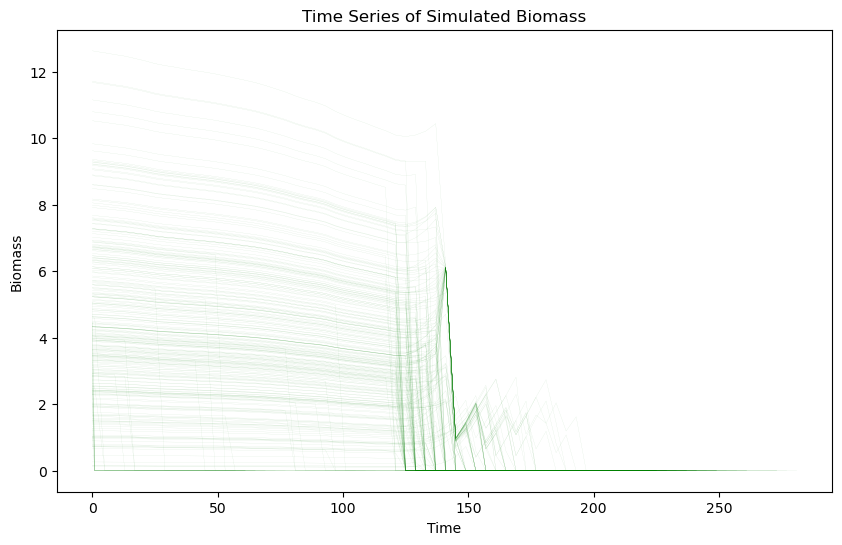

In [35]:
DB=output.loc[:,'DB',:]
DB_np=DB['vegetation__repro_biomass']
cs=DB_np.reorder_levels(['item_id','time']).sort_index()
groups = cs.groupby(level=0)

plt.figure(figsize=(10, 6))
for item, group in groups:
    x = group.index.get_level_values(1)
    y = group.values
    plt.plot(x, y, linewidth=0.1, color='green', alpha=0.25)

plt.xlabel('Time')
plt.ylabel('Biomass')
plt.title('Time Series of Simulated Biomass')
plt.show()

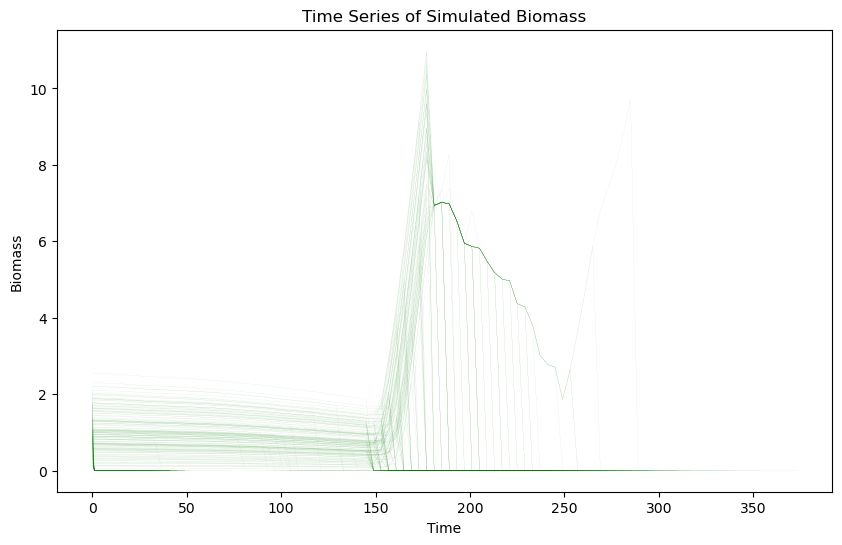

In [34]:
BTS=output.loc[:,'BTS',:]
#fig, ax = plt.subplots()
#ax.set_xlim(0,2045)
#ax.set_ylim(0,10)
BTS_np=BTS['vegetation__repro_biomass']

cs=BTS_np.reorder_levels(['item_id','time']).sort_index()
groups = cs.groupby(level=0)

plt.figure(figsize=(10, 6))
for item, group in groups:
    x = group.index.get_level_values(1)
    y = group.values
    plt.plot(x, y, linewidth=0.1, color='green', alpha=0.25)

plt.xlabel('Time')
plt.ylabel('Biomass')
plt.title('Time Series of Simulated Biomass')
plt.show()

Here we look at some outputs at the final time step. Note that the final timestep may be in dormant season so biomass represents only the persistent parts. The number of plants is still tracked but annual plants are removed.

In [ ]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Total Biomass (g)', cmap='Greens')

In [ ]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants', cmap='Greens')

In [ ]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)', cmap='YlGn')

grid.close()

grid = netcdf_file('crop.nc', 'r')
print(grid.__dict__)